In [1]:
import sqlite3
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter("ignore")

In [15]:
database = './database.sqlite'
conn = sqlite3.connect(database)

playerData = pd.read_sql("SELECT * FROM Player;", conn)
playerStatsData = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
teamData = pd.read_sql("SELECT * FROM Team;", conn)
matchData = pd.read_sql("SELECT * FROM Match;", conn)

rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]

matchData.dropna(subset = rows, inplace = True)
matchData = matchData.tail(554)

In [16]:
def get_match_label(match):
    ''' Give a label of game result for a given match. '''
    
    homeGoals = match['home_team_goal']
    awayGoals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 
 
    if homeGoals > awayGoals:
        label.loc[0,'label'] = "Win"
    if homeGoals == awayGoals:
        label.loc[0,'label'] = "Draw"
    if homeGoals < awayGoals:
        label.loc[0,'label'] = "Defeat"
      
    return label.loc[0]

def get_fifa_stats(match, playerStats):
    
    matchID =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    playerStatsMatch = pd.DataFrame()
    names = []
    
    for player in players:
        playerID = match[player]
        stats = playerStats[playerStats.player_api_id == playerID]
        currentStats = stats[stats.date <= date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(playerID) == True:
            overallRating = pd.Series(40)
        else:
            currentStats.reset_index(inplace = True, drop = True)
            overallRating = pd.Series(currentStats.loc[0, "overall_rating"])

        name = "{}_overall_rating".format(player)
        names.append(name)

        playerStatsMatch = pd.concat([playerStatsMatch, overallRating], axis = 1)
    
    playerStatsMatch.columns = names
    playerStatsMatch['match_api_id'] = matchID

    playerStatsMatch.reset_index(inplace = True, drop = True)

    return playerStatsMatch.iloc[0]

In [17]:
def get_overall_fifa_rankings(playerAttriubte):
    
    dataLocal = playerAttriubte

    data = dataLocal.loc[:,(playerAttriubte.columns.str.contains('overall_rating'))]
    data.loc[:,'match_api_id'] = dataLocal.loc[:,'match_api_id']

    return data


def get_last_matches(matches, date, team, x = 10):
    
    x = x - 1

    teamMatches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
    lastMatches = teamMatches[teamMatches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]

    return lastMatches

def get_last_facing(matches, date, homeTeam, awayTeam, x = 10):
    
    x = x - 1
    
    homeMatches = matches[(matches['home_team_api_id'] == homeTeam) & (matches['away_team_api_id'] == awayTeam)]    
    awayMatches = matches[(matches['home_team_api_id'] == awayTeam) & (matches['away_team_api_id'] == homeTeam)]  
    totalMatches = pd.concat([homeMatches, awayMatches])

    try:    
        lastMatches = totalMatches[totalMatches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        lastMatches = totalMatches[totalMatches.date < date].sort_values(by = 'date', ascending = False).iloc[0:totalMatches.shape[0],:]
        
    return lastMatches

def get_goals(matches, team):

    homeGoals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    awayGoals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    totalGoals = homeGoals + awayGoals

    return totalGoals

def get_goals_conceided(matches, team):

    homeGoalsConceided = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    awayGoalsConceided = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    totalGoalsConceided = homeGoalsConceided + awayGoalsConceided

    return totalGoalsConceided

def get_wins(matches, team):
    
    homeWins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    awayWins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    totalWins = homeWins + awayWins

    return totalWins

def get_match_features(match, matches, x = 10):

    date = match.date
    homeTeam = match.home_team_api_id
    awayTeam = match.away_team_api_id

    matchesHomeTeam = get_last_matches(matches, date, homeTeam)
    matchesAwayTeam = get_last_matches(matches, date, awayTeam)
    
    lastMatchesAgainst = get_last_facing(matches, date, homeTeam, awayTeam, x = 5)
    
    homeGoals = get_goals(matchesHomeTeam, homeTeam)
    awayGoals = get_goals(matchesAwayTeam, awayTeam)
    homeGoalsConceided = get_goals_conceided(matchesHomeTeam, homeTeam)
    awayGoalsConceided = get_goals_conceided(matchesAwayTeam, awayTeam)
    
    result = pd.DataFrame()
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
    result.loc[0, 'home_team_goals_difference'] = homeGoals - homeGoalsConceided
    result.loc[0, 'away_team_goals_difference'] = awayGoals - awayGoalsConceided
    result.loc[0, 'games_won_home_team'] = get_wins(matchesHomeTeam, homeTeam) 
    result.loc[0, 'games_won_away_team'] = get_wins(matchesAwayTeam, awayTeam)
    result.loc[0, 'games_against_won'] = get_wins(lastMatchesAgainst, homeTeam)
    result.loc[0, 'games_against_lost'] = get_wins(lastMatchesAgainst, awayTeam)

    return result.loc[0]


def create_feables(matches, fifa, x = 10):

    fifaStats = get_overall_fifa_rankings(fifa)
    matchStats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)   

    dummies = pd.get_dummies(matchStats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    matchStats = pd.concat([matchStats, dummies], axis = 1)
    matchStats.drop(['league_id'], inplace = True, axis = 1)

    labels = matches.apply(get_match_label, axis = 1)

    features = pd.merge(matchStats, fifaStats, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    feables.dropna(inplace = True)
    
    print('Les caractéristiques et les lables sont collectés.')

    return feables

In [18]:
fifaData = matchData.apply(lambda x :get_fifa_stats(x, playerStatsData), axis = 1)
print('Les donnés de FIFA sont collectés.')
feables = create_feables(matchData, fifaData)
donne = feables.drop('match_api_id', axis = 1)

Les donnés de FIFA sont collectés.
Les caractéristiques et les lables sont collectés.


In [19]:
labels = donne.loc[:,'label']
features = donne.drop('label', axis = 1)
features.head(5)

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_24558.0,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,-8.0,-5.0,1.0,4.0,0.0,0.0,1,58.0,58.0,56.0,...,63.0,65.0,64.0,58.0,63.0,73.0,69.0,68.0,60.0,70.0
1,6.0,-1.0,4.0,2.0,1.0,0.0,1,62.0,61.0,60.0,...,66.0,57.0,59.0,52.0,65.0,64.0,63.0,59.0,69.0,64.0
2,6.0,-5.0,3.0,2.0,0.0,0.0,1,69.0,60.0,66.0,...,60.0,62.0,53.0,62.0,66.0,60.0,58.0,58.0,63.0,68.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1,64.0,61.0,75.0,...,65.0,62.0,74.0,67.0,69.0,65.0,66.0,72.0,73.0,78.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1,62.0,53.0,64.0,...,58.0,66.0,53.0,65.0,63.0,62.0,69.0,55.0,69.0,67.0


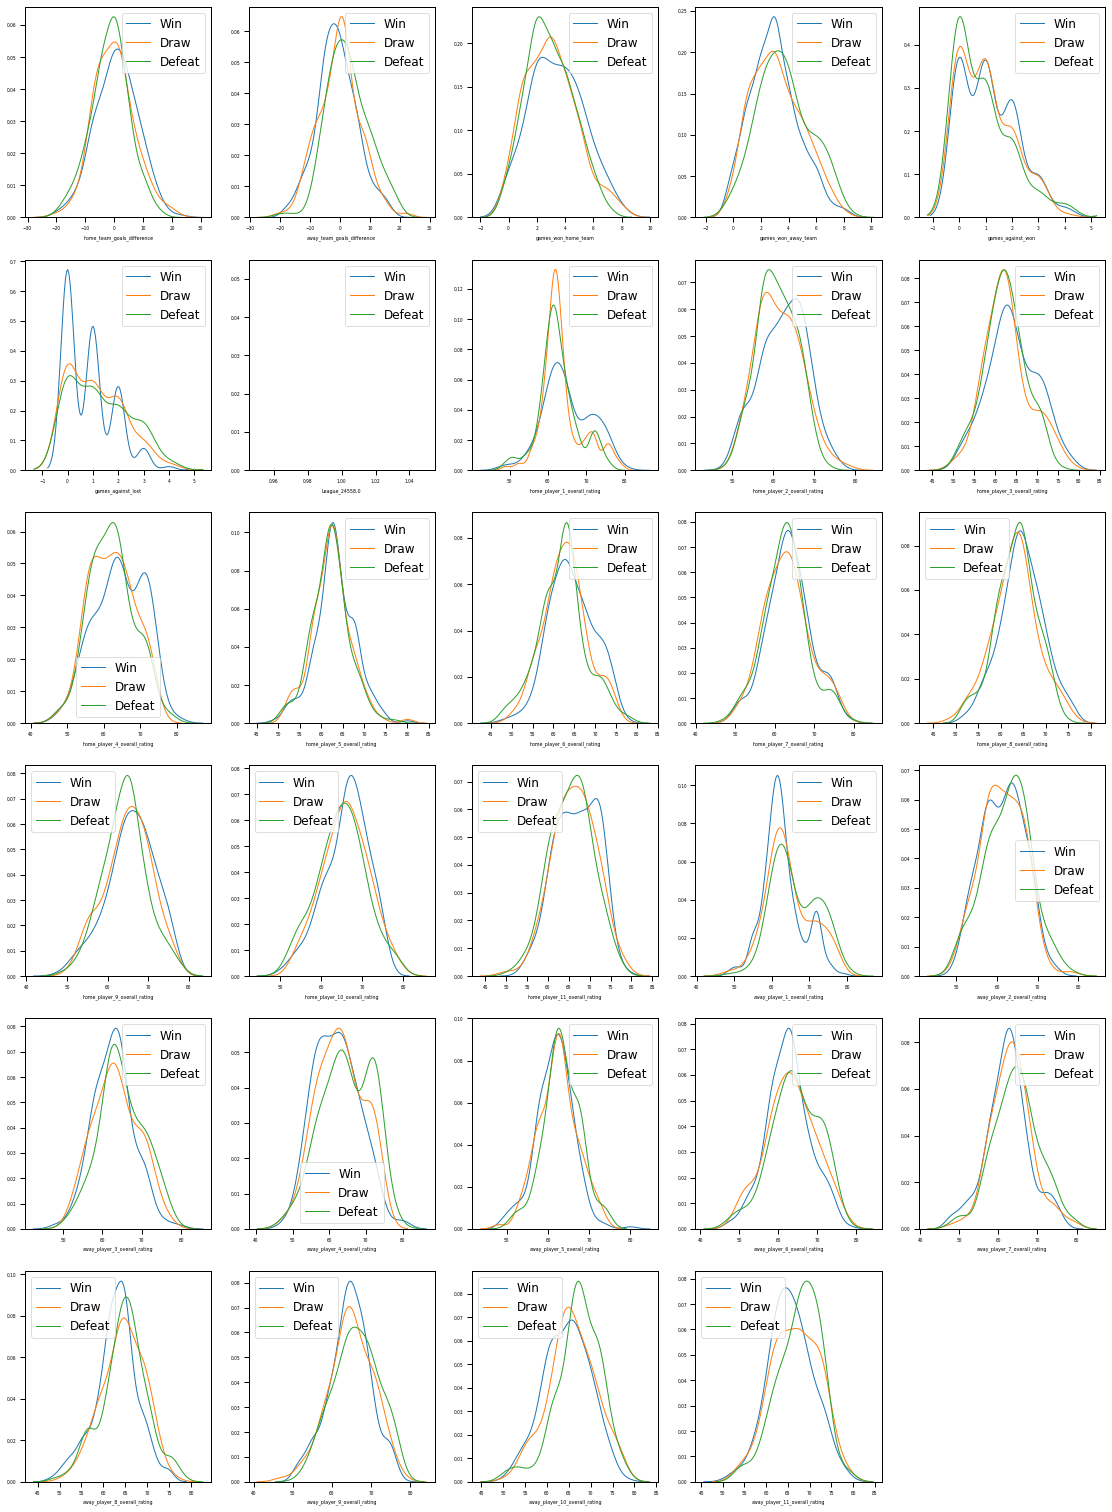

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(1)
fig.subplots_adjust(bottom = -3, left = 0.5, top = 3, right = 3)

i = 1
for col in features.columns:
    
    sns.set_context("paper", font_scale = 0.5, rc = {"lines.linewidth": 1})
    plt.subplot(7, 5, i)
    j = i - 1

    sns.distplot(donne[donne['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
    sns.distplot(donne[donne['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
    sns.distplot(donne[donne['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
    
    plt.legend(loc = 0, prop = {'size': 12});
    i = i + 1

plt.show()

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# La base d'apprentisage et la base de test
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2,
                                                                        random_state = 42, 
                                                                        stratify = labels)

X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate,
                                                              test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

# Validation croisée
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 5)

NameError: name 'features' is not defined

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, accuracy_score

from sklearn.decomposition import PCA, FastICA

KNN = KNeighborsClassifier()
LOG = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
RF = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB = GaussianNB()

clfs = [KNN, LOG, RF, AB, GNB]

featureLen = features.shape[1]
scorer = make_scorer(accuracy_score)

parametersKNN = {'clf__n_neighbors': [3, 5, 10], 
                  'dm_reduce__n_components': np.arange(5, featureLen, np.around(featureLen/5))}
parametersLOG = {'clf__C': np.logspace(1, 1000, 5), 
                  'dm_reduce__n_components': np.arange(5, featureLen, np.around(featureLen/5))}
parametersRF = {'clf__max_features': ['auto', 'log2'], 
                 'dm_reduce__n_components': np.arange(5, featureLen, np.around(featureLen/5))}
parametersAB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'dm_reduce__n_components': np.arange(5, featureLen, np.around(featureLen/5))}
parametersGNB = {'dm_reduce__n_components': np.arange(5, featureLen, np.around(featureLen/5))}


parameters = {clfs[0]: parametersKNN, clfs[1]: parametersLOG, clfs[2]: parametersRF, 
              clfs[3]: parametersAB, clfs[4]: parametersGNB}

pca = PCA()
dimensionReductions = [pca] 

In [23]:
clf = LOG
clf.fit(X_train, y_train)
print("Le score de {} pour base d’apprentissage: {:.4f}.".format(clf.__class__.__name__,
                                                              accuracy_score(y_train, clf.predict(X_train))))
print("Le score de {} pour base de test: {:.4f}.".format(clf.__class__.__name__,
                                                         accuracy_score(y_test, clf.predict(X_test))))


Le score de LogisticRegression pour base d’apprentissage: 0.5097.
Le score de LogisticRegression pour base de test: 0.3514.


In [24]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

def predict_labels(clf, best_pipe, features, target):
    
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))

    return accuracy_score(target.values, y_pred)

def train_classifier(clf, dimensionReductions, X_train, y_train, cv_sets, params, scorer, jobs, 
                     best_components = None, best_params = None):
    
    estimators = [('dm_reduce', dimensionReductions), ('clf', clf)]
    pipeline = Pipeline(estimators)

    params['dm_reduce__n_components'] = params['dm_reduce__n_components'].astype(int)
    gridObj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, 
                                           cv = cv_sets, n_jobs = jobs)
    gridObj.fit(X_train, y_train)
    bestPipe = gridObj.best_estimator_
    
    print("L'apprentisage de {} est fini,e".format(clf.__class__.__name__))

    return bestPipe


def train_calibrate_predict(clf, dimensionReductions, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test,
                            cv_sets, params, scorer, jobs, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''

    print("L'apprentisage de {} avec {}...".format(clf.__class__.__name__, dimensionReductions.__class__.__name__))

    bestPipe = train_classifier(clf, dimensionReductions, X_train, y_train, cv_sets, params, scorer, jobs)

    clf = CalibratedClassifierCV(bestPipe.named_steps['clf'], cv = 'prefit', method = 'isotonic')
    clf.fit(bestPipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)

    print("Le score de {} pour base d’apprentissage: {:.4f}.".format(clf.__class__.__name__,
                                                                     predict_labels(clf, bestPipe, X_train,
                                                                                    y_train)))
    print("Le score de {} pour base de test: {:.4f}.".format(clf.__class__.__name__,
                                                             predict_labels(clf, bestPipe, X_test, y_test)))
    
    return clf, bestPipe.named_steps['dm_reduce'], predict_labels(clf, bestPipe, X_train, y_train), predict_labels(clf, bestPipe, X_test, y_test)


def find_best_classifier(classifiers, dimensionReductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v,
                         cv_sets, params, jobs):

    clfsReturn = []
    dimensionReductionsReturn = []
    trainScores = []
    testScores = []

    for dm in dimensionReductions:
        for clf in clfs:
            clf, dimensionReductions, trainScore, testScore = train_calibrate_predict(clf = clf, dimensionReductions = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs)
    
            clfsReturn.append(clf)
            dimensionReductionsReturn.append(dimensionReductions)
            trainScores.append(trainScore)
            testScores.append(testScore)

    return clfsReturn, dimensionReductionsReturn, trainScores, testScores

In [25]:
n_jobs = 1
clfsFB, dimensionReductionsFB, trainScores, testScores = find_best_classifier(clfs, dimensionReductions, scorer,
                                                                            X_train, y_train, X_calibrate,
                                                                            y_calibrate, X_test, y_test, 
                                                                            cv_sets, parameters, n_jobs)

L'apprentisage de KNeighborsClassifier avec PCA...
Trained KNeighborsClassifier
Le score de CalibratedClassifierCV pour base d’apprentissage: 0.5290.
Le score de CalibratedClassifierCV pour base de test: 0.4685.
L'apprentisage de LogisticRegression avec PCA...
Trained LogisticRegression
Le score de CalibratedClassifierCV pour base d’apprentissage: 0.5032.
Le score de CalibratedClassifierCV pour base de test: 0.4505.
L'apprentisage de RandomForestClassifier avec PCA...
Trained RandomForestClassifier
Le score de CalibratedClassifierCV pour base d’apprentissage: 1.0000.
Le score de CalibratedClassifierCV pour base de test: 0.4144.
L'apprentisage de AdaBoostClassifier avec PCA...
Trained AdaBoostClassifier
Le score de CalibratedClassifierCV pour base d’apprentissage: 0.4839.
Le score de CalibratedClassifierCV pour base de test: 0.4685.
L'apprentisage de GaussianNB avec PCA...
Trained GaussianNB
Le score de CalibratedClassifierCV pour base d’apprentissage: 0.5129.
Le score de CalibratedClas

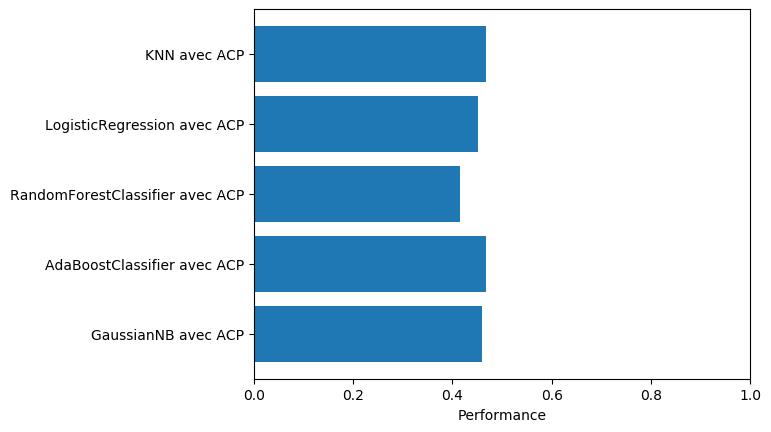

In [26]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
modules = ('KNN avec ACP', 'LogisticRegression avec ACP', 'RandomForestClassifier avec ACP',
          'AdaBoostClassifier avec ACP', 'GaussianNB avec ACP')


y_pos = np.arange(len(modules))
performance = testScores

plt.xlim((0,1))

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(modules)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')

plt.show()